In [11]:
!pip install tensorflow matplotlib seaborn scikit-learn gradio

Defaulting to user installation because normal site-packages is not writeable


In [23]:
import tensorflow as tf

img_size = (124, 124)
batch_size = 32
data_dir = "dataset" 

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [25]:
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

base_model = EfficientNetV2B2(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 124, 124,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 124, 124,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 124, 124,  │          0 │ rescaling_5[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 124, 124,  │          0 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.2137 - loss: 1.7689 - val_accuracy: 0.1802 - val_loss: 1.7537
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.2135 - loss: 1.7471 - val_accuracy: 0.1762 - val_loss: 1.7568
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 668ms/step - accuracy: 0.2137 - loss: 1.7331 - val_accuracy: 0.2040 - val_loss: 1.7407
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accuracy: 0.1981 - loss: 1.7378 - val_accuracy: 0.1921 - val_loss: 1.7581
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.2032 - loss: 1.7549 - val_accuracy: 0.2436 - val_loss: 1.7603
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 641ms/step - accuracy: 0.2178 - loss: 1.7425 - val_accuracy: 0.2416 - val_loss: 1.7402
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.2338 - loss: 1.7528 - val_accuracy: 0.1921 - val_loss: 1.7506
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.2170 - loss: 1.7463 - val_accu

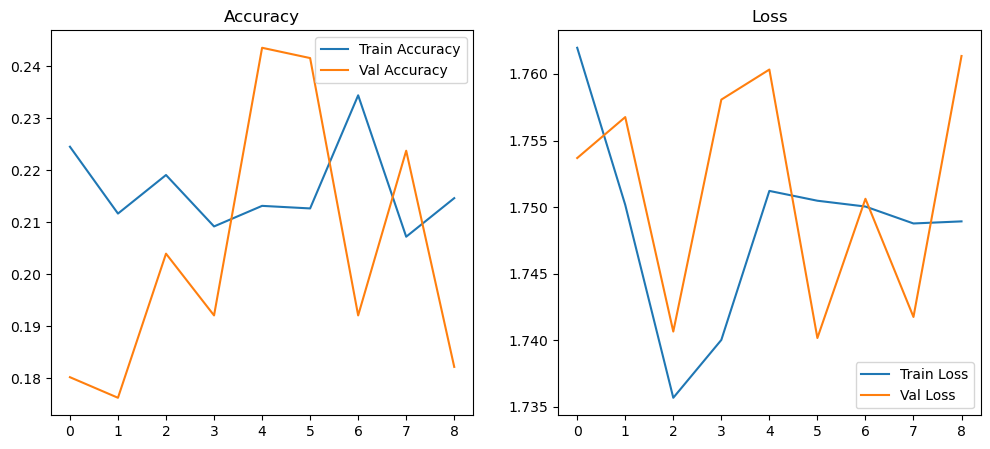

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()
